In [1]:
import SimpleITK as sitk
import pydicom
from matplotlib import pyplot as plt

In [2]:
def display_metadata(dcm_file, expl):
    """Reads a dicom file, and  takes an explanation variable
    Parameters
    ----------
    dcm_file : str
      path to dicom file
    expl : str
      name of corresponding Window Center Width Explanation.
    Returns
    -------
    center, width, VOILUTFunction, total_bits
    """
    dcm = pydicom.read_file(dcm_file)
    center = dcm.WindowCenter
    width = dcm.WindowWidth
    
    if hasattr(dcm, 'VOILUTFunction'):
        lut_func = dcm.VOILUTFunction.strip()
    else:
        lut_func = ''

    if dcm.SamplesPerPixel == 1:
        if dcm.PhotometricInterpretation == 'MONOCHROME1':
#             raise NotImplementedError('The image needs to be inverted. Not implemented.')
              print('The image needs to be inverted.') 
              inverted=True
        else:
              inverted=False
    return center, width, lut_func, dcm.BitsStored,inverted

In [3]:
def linear_lut(image, center, width,out_bits,is_inverted):
    """If VOILUTFunction in the dicom header is equal to LINEAR_EXACT,
    apply this function for visualisation.
    """
    lower_bound = center - (width - 1)/2
    upper_bound = center + (width - 1)/2

    min_max = sitk.MinimumMaximumImageFilter()
    min_max.Execute(image)

    image = sitk.IntensityWindowing(image,
                                    lower_bound, upper_bound,
                                    min_max.GetMinimum(),
                                    min_max.GetMaximum())
    
    if is_inverted==True:
        image=sitk.BitwiseNot(image)

    return sitk.GetArrayFromImage(image)

In [ ]:
def sigmoid_lut(image, center, width,out_bits,is_inverted ):
    """If VOILUTFunction in the dicom header is equal to SIGMOID,
    apply this function for visualisation.
    """
    array = sitk.GetArrayFromImage(image).astype(np.float)
    array = np.round((2**out_bits - 1)/(1 + np.exp(-4*(array - center)/width))).astype(np.int)
    ret_image = sitk.GetImageFromArray(array)
    ret_image.SetSpacing(image.GetSpacing())
    ret_image.SetOrigin(image.GetOrigin())
    ret_image.SetDirection(image.GetDirection())
    
    if is_inverted==True:
        ret_image=sitk.BitwiseNot(ret_image)

    return sitk.GetArrayFromImage(ret_image)

In [4]:
dcm_path="DICOM_103_47565_1.3.51.0.7.401618858.7814.60744.45792.62589.50088.13355.dcm"
[dcm_center,dcm_width,lut_func,bits,is_inverted]=display_metadata(dcm_path,"SOFTER")

In [7]:
if lut_func == 'SIGMOID':
        print('Applying `SIGMOID`.')
        np_dcm=sigmoid_lut(sitk.ReadImage(dcm_path),dcm_center,dcm_width,bits,is_inverted)
    elif lut_func == '':
        print('Applying `LINEAR`.')
        np_dcm=linear_lut(sitk.ReadImage(dcm_path),dcm_center,dcm_width,bits,is_inverted)


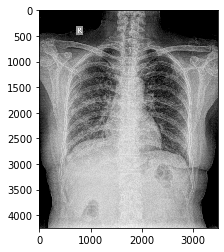

In [9]:
plt.imshow(np_dcm[0,:,:],cmap='gray')